# Convert embeddings to sqlite

In [1]:
from gensim.models import KeyedVectors
from gensim import models
from IPython.display import Markdown
import pandas as pd
import os

In [2]:
import dhlab.graph_networkx_louvain as gnl
import networkx as nx

from collections import Counter

In [3]:
model_file = "/mnt/disk2/norn/embeddings/digibok_1850-1900.txt.model"

In [4]:
model = KeyedVectors.load(model_file)    #load_word2vec_format(model_file, binary=True)
d = model.wv
del model

In [8]:
d.most_similar('Angst',topn= 40)

[('Angest', 0.9118576645851135),
 ('Rædsel', 0.8844659328460693),
 ('Smerte', 0.8805304169654846),
 ('Skræk', 0.8749999403953552),
 ('Fortvivlelse', 0.870319128036499),
 ('Fortvilelse', 0.8485856652259827),
 ('Sorg', 0.8474487066268921),
 ('Uro', 0.8347920179367065),
 ('Dødsangst', 0.8345738649368286),
 ('Kval', 0.8337345123291016),
 ('Sjæleangst', 0.8329892158508301),
 ('Forfærdelse', 0.8294442892074585),
 ('Forskrækkelse', 0.8231632709503174),
 ('Ængstelse', 0.8195300698280334),
 ('Kummer', 0.8171816468238831),
 ('Sjælekval', 0.8061849474906921),
 ('Gru', 0.7973834872245789),
 ('Hjerteangst', 0.7962251305580139),
 ('Bekymring', 0.7936487197875977),
 ('Jammer', 0.7920781373977661),
 ('Frygt', 0.7843427658081055),
 ('Smærte', 0.7787533402442932),
 ('Sørgmodighed', 0.7763521671295166),
 ('Samvittighedskval', 0.7692593932151794),
 ('Modløshed', 0.7673736214637756),
 ('Bedrøvelse', 0.7631320357322693),
 ('Graad', 0.7586113214492798),
 ('Elendighed', 0.7583057880401611),
 ('Angft', 0.75821

In [9]:
T = ""
for x in "Himlen Havet Sjøen Øine Haand Aand".split():
    try:
        text = f"### {x} \n {', '.join([x[0] for x in d.most_similar(x, topn=15)])}\n\n"
    except:
        text = f"### {x} \n"
    T += text
    
Markdown(T)
    

### Himlen 
 Himmelen, Skyen, Skyerne, Jorden, Himmel, Ham, Solen, Mørket, Himlene, Lyset, Himlens, Evigheden, Høie, Dybet, Helvede

### Havet 
 Søen, Oceanet, Verdenshavet, Vandet, Bølgerne, Dybet, Bjergene, Sjøen, Floden, Klipperne, Vandene, Kysten, Havfladen, Bjærgene, Sletten

### Sjøen 
 Søen, Isen, Fjorden, Revet, Fjæren, Tjernet, Elven, Stranden, Sjøerne, Fjeldet, Fossen, Skjærene, Baaden, Soen, Havet

### Øine 
 Øjne, Oine, Ojne, Qine, Ansigt, Blikke, ØQine, ØPjne, Aasyn, Øino, Øjno, ØOine, Øren, Ansigter, Ojns

### Haand 
 Arm, Finger, Haaud, Mund, Hænder, Skulder, Hånd, Hagnd, Tommelfinger, Pegefinger, Næve, Arme, Haanden, Albue, Hæl

### Aand 
 Kraft, Sjæl, Tro, Aanden, Sjel, Gjerning, Vilje, Åand, Villie, Kjærlighed, Lære, Fylde, Aaud, Krast, Natur



In [11]:
def make_edges(w, topn=20, visited=None, model = d, level = 0):
    edges = []
    if w not in visited:
        visited.append(w)
        try:
            gdata =  model.most_similar(w, topn=topn)
            edges += [(w, g[0], g[1]) for g in gdata]
            #print(visited)
            if level > 0:
                for g in gdata:
                    l = level - 1
                    edges += make_edges(g[0], topn=topn, visited = visited, level=l)
                    #print(l,edge)
        except:
            pass
            #print("problem", w)
    return edges

def graf(w, model = d, top = 20):
    edges = make_edges(w, topn = top, visited=[], model=model,level = 1)
    G = nx.DiGraph()
    G.add_weighted_edges_from(edges)
    return G

def show_centralities(G, size=10):
    cols = [Counter(nx.betweenness_centrality(G)).most_common(size),
            Counter(nx.degree_centrality(G)).most_common(size),
            Counter(nx.in_degree_centrality(G)).most_common(size),
            Counter(nx.out_degree_centrality(G)).most_common(size)
           ]
    names = ["Betweennes", "Degree", "Indegree", "Outdegree"]
    res = zip(names, cols)
    cents = pd.concat(map(lambda x: pd.DataFrame(x[1], columns =['index', x[0]]).set_index('index'), res), axis = 1)
    return cents

In [12]:
G = graf('Industri',model=d, top=15)

gnl.show_communities(G)

Industri-lndustri :  Industri, lndustri, Indaustri, Værkflid, Fabrikindustri, Textilindustri, Industrii, Indastri, Kysthandel, Handel-, Uldindustri

Fabrikdrift-Bergværksdrift :  Fabrikdrift, Bergværksdrift, Bjergværksdrift, Kvæg-, Faareavl, Bergverksdrift, Grubedrift, Fabrikvæsen, Haandværksdrift, Fabrik-, Eksport, Skovdrift, Kvægdrift

Husflid-Agerdyrkning :  Husflid, Agerdyrkning, Jorddyrkning, Havedyrkning, Havebrug, Landbrug, Husfliden, Huusflid, Kvægavl, Agerbrug, Kornavl, Qvægavl, Fædrift, Skovbrug, Landhusholdning

Frugtavl-Kornhandel :  Frugtavl, Kornhandel, Indusiri, Silkeavl, Tobaksavl, Bomuldsindustri, Flodskibsfart, Biavl, Skibsbyggeri, Silkemanufakturer, Vinavl, Silkeindustri, Klædefabrikation, Humleavl, Kvæghandel, Linnedmanufakturer, Vindyrkning, Linnedvæverier, Linned-, Korn-, Tobaks-, Uldhandel, Høravl, Frugt-, Tømmerhandel, Vinhandel, Klæde-, Vin-, Bomuldsog, Uld-

Kunstflid-Fabrikvirksomhed :  Kunstflid, Fabrikvirksomhed, Skibsfart, Handel, Sjøfart, Husindustri, Træ

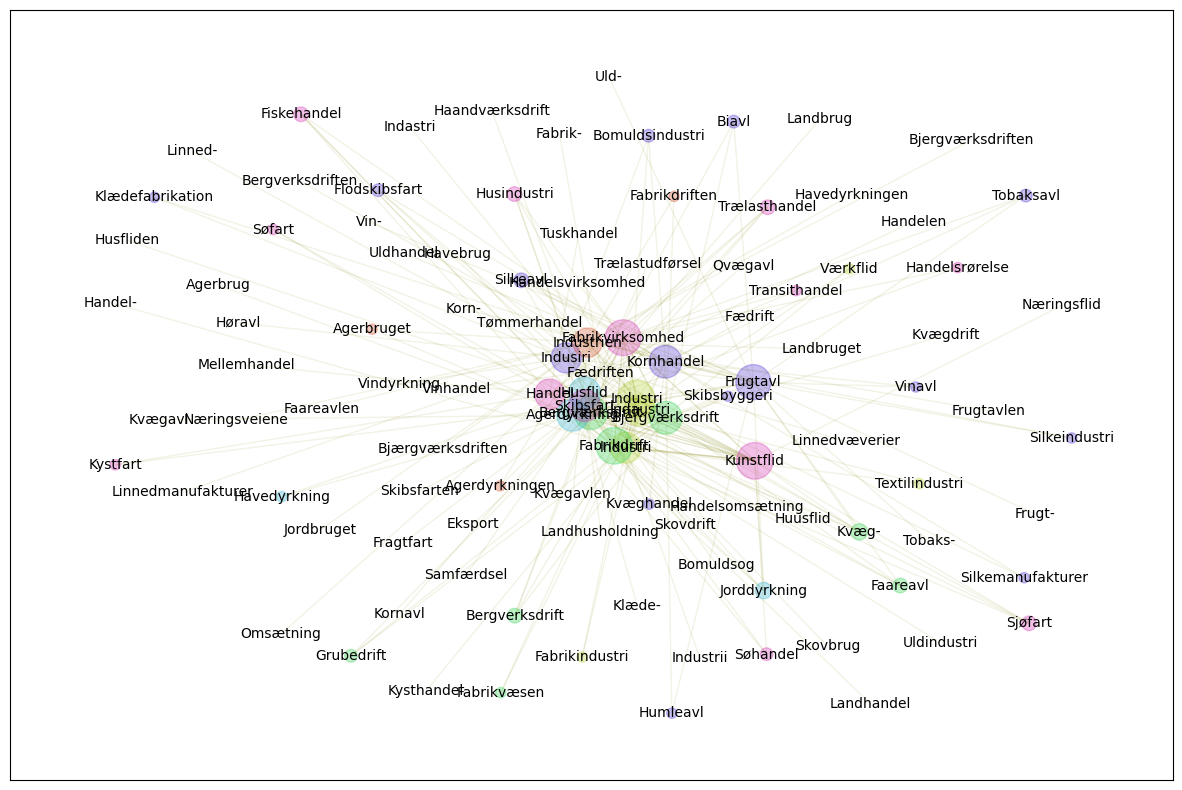

In [13]:
gnl.show_graph(G, spread=0.01)

In [33]:
def combine(words, top = 20, model = None):
    G = nx.DiGraph()
    for w in words:
        G = nx.compose(G, graf(w, model= model,top=top))
    return G

In [67]:
G = combine("Vinskibelighed Vindskibelighed Industri Kunst".split(), model = d, top = 20)

In [51]:
(show_centralities(G, 20).fillna(0)
    .sort_values(by=['Degree','Indegree','Betweennes','Outdegree',], ascending=False)
    .style
    .background_gradient(axis = 1))

,Betweennes,Degree,Indegree,Outdegree
index,,,,
Arbeidsomhed,0.003133,0.080078,0.041016,0.039062
Arbejdsomhed,0.003016,0.078125,0.039062,0.039062
Ordenssands,0.000000,0.074219,0.035156,0.039062
Vindskibelighed,0.006268,0.072266,0.033203,0.039062
Stræbsomhed,0.003616,0.070312,0.031250,0.039062
Driftighed,0.013066,0.068359,0.029297,0.039062
Industri,0.003462,0.068359,0.029297,0.000000
Nøjsomhed,0.000000,0.066406,0.027344,0.039062
Vinskibelighed,0.004128,0.064453,0.025391,0.039062


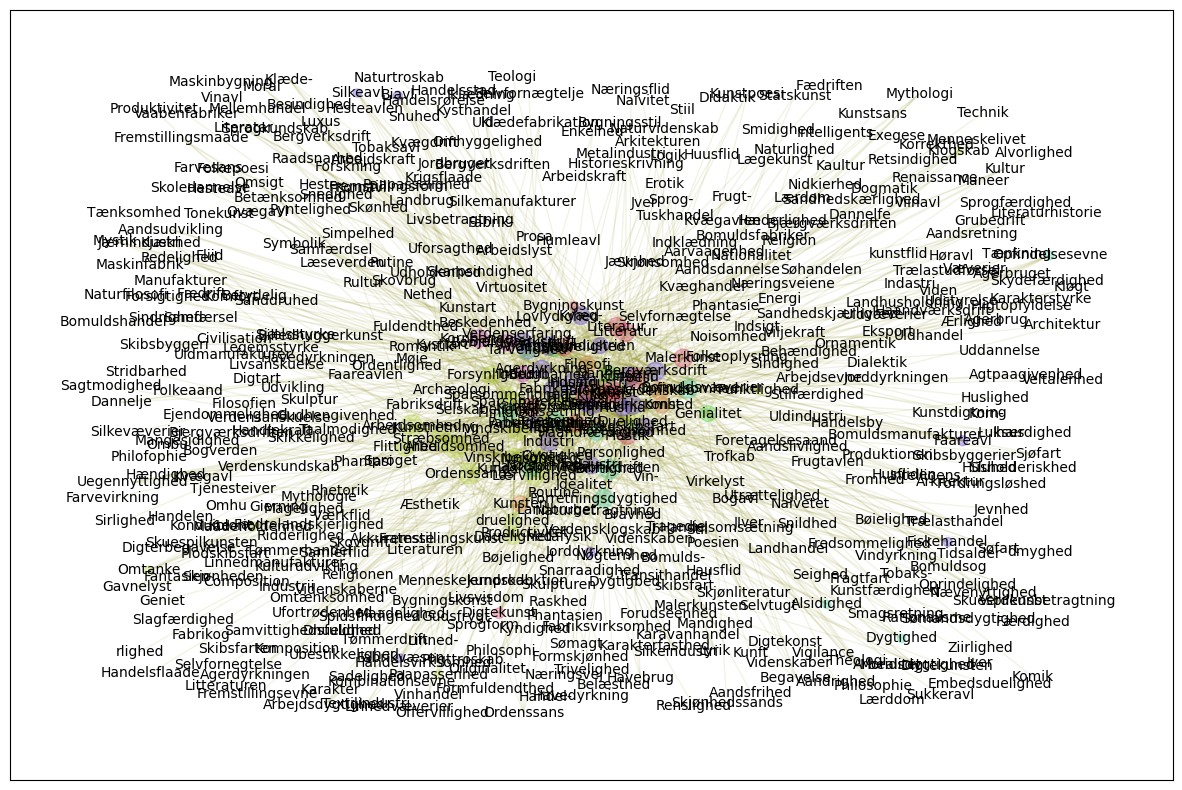

In [52]:
gnl.show_graph(G, spread = 0.003)

In [53]:
gnl.show_communities(G)

Arbeidsomhed-Arbejdsomhed :  Arbeidsomhed, Arbejdsomhed, Ordenssands, Vindskibelighed, Stræbsomhed, Nøjsomhed, Vinskibelighed, Ædruelighed, Sparsomhed, Duelighed, Lærvillighed, Forsynlighed, Nøisomhed, Flittighed, Arbeidssomhed, Sparsommelighed, Retskaffenhed, Flid, Haardførhed, druelighed, Dauelighed, Maadeholdenhed, Omtanke, Klogskab, Punktlighed, Paapassenhed, Ordenssans, Samvittighedsfuldhed, Uegennyttighed, Paapasselighed, Omtænksomhed, Gavnelyst, Bravhed, Akkuratesse, Omsigt, Fredsommelighed, Redelighed, Gudhengivenhed, Pligttroskab, Karakterfasthed, Ufortrødenhed, Fliid, Maadelighed, Husholderiskhed, Skjønsomhed, Kjækhed, Betænksomhed, Konduite, Utrættelighed, Nøgternhed, Ubestikkelighed, Ihærdighed, Øygtighed, Mandighed, Selvtugt, Agtpaagivenhed, Forsigtighed, Lovlydighed, Karakterstyrke, Noisomhed, Embedsduelighed, rlighed, Omhu, Udholdenhed, Skikkelighed, Pligtopfyldelse, Trivelighed, Ærlighed, Vigilance, Kyndighed, Tænksomhed, Sagtmodighed, dmyghed, Besindighed, Iver, Skydef

In [54]:
gnl.show_cliques(G)

(3, 1) Paapasselighed, Omtænksomhed, Sparsommelighed, Ordenssans, Foretagelsesaand, Gavnelyst, Legemsstyrke, Gudhengivenhed, Virtuositet, Husholderiskhed, Omtanke, Belæsthed, Arbeidsomhed, Retskaffenhed, Selvtugt, Bravhed, Nøjsomhed, Nøisomhed, Sindrighed, Agtpaagivenhed, Maadeholdenhed, Raadsnarhed, Fordringsløshed, Forsigtighed, Sparsomhed, Konduite, Opfindelsesevne, Lærenemhed, Opfindsomhed, Flinkhed, Aandslivlighed, Nøgternhed, Skarpsindighed, Akkuratesse, Kundskabsfylde, Virkelyst, Kunst, Flid, Foretagsomhed, Lovlydighed, Flittighed, Vinskibelighed, Vindskibelighed, Haardførhed, Kunstfærdighed, Forretningsdygtighed, Handlekraft, Haandfærdighed, Begavelse, Mangesidighed, Huslighed, Arbeidslyst, Arbeidssomhed, Klogskab, Snarraadighed, Raskhed, druelighed, Tarvelighed, Lærvillighed, Omsigt, Alsidighed, Menneskekundskab, Dauelighed, Samvittighedsfuldhed, Duelighed, Ædruelighed, Dygtighed, Smidighed, Noisomhed, Arbeidsdygtighed, Øygtighed, Ufortrødenhed, Stræbsomhed, Fredsommelighed, D

In [61]:
z = gnl.make_cliques_from_graph(G.to_undirected())[1]

In [63]:
for x in z:
    

(3, 1)
(3, 2)
(3, 3)
(4, 1)
(4, 2)
(4, 3)
(5, 1)
(5, 2)
(5, 3)
(6, 1)
(6, 2)
(6, 3)
(6, 4)
(6, 5)
(7, 1)
(7, 2)
(7, 3)
(8, 1)
(8, 2)
(9, 1)


In [56]:
gnl.make_cliques_from_graph??

Signature: gnl.make_cliques_from_graph(G, lable_num=2)
Docstring: <no docstring>
Source:   
def make_cliques_from_graph(G, lable_num=2):
    ggg = G
    centrals = nx.closeness_centrality(ggg)
    coms = kcliques(ggg)
    sg = subsetgraph(coms, centrals, lable_num)
    return (ggg, coms, sg)
File:      ~/anaconda3/lib/python3.11/site-packages/dhlab/legacy/graph_networkx_louvain.py
Type:      function

In [68]:
Kyst = combine("Kystbyen Kystby".split(), model = d, top = 20)

In [69]:
By = combine("By Byen Byens Byene".split(), model = d, top = 20)

In [71]:
Hus = combine("Hus Huset".split(), model = d, top = 20)

In [127]:
Fjell = combine("Fjell Fjeldet Fjeld fjell fjellet".split(), model = d, top = 20)

In [128]:
gnl.show_communities(Fjell)

Tindar-Fjøll :  Tindar, Fjøll, Fossar, Aasar, Nutar, Fjelli, Bylgja, Fjøra, Vollar, Engjer, Votn, Lauv, Toppar, Fjellet, Øyar, Bakkar, Strender, Straum, Fjell, Snjoen, glitrande, Elvar, Bekkjer, haagt, blømande, Lidi, Skuggar, Skodda, Baara, Vindaugo, Elvi, Hamrar, lokkar, Drakar, Skogar, glimande, Baaror, Glasi, Vatnet, Krokar, Draugar, Ringar, Doggi, Holmar, Fjellom, Aakrar, Lauvet, Trei, Straumen, leikande, stengjer, Bergi, Engjar, Straumar, tettbygde, Bekk, Bylgjor, Fjordar, Tuva, Vengjer, Heidar, Skjoldar, Baatar, Røter, snøkvite, Bergom, Taket, symjande, Bjørki, Rosor, øyar, Bakkarne, Fjordarne, Aai, Rosur, Beini, Tufti, Fjellgardar, rjukande, Fuglar, øyarne, Fargar, grøne, Fuglarne, nordanfyre, Deilder, Dogg, Graset, Elden, Imillom, Treet, Røyk, blømer, Blomarne, Kyrfja, Veggjer, lauv, Flaum, Golv, ljomar, Millom, Sjoen, Haugar, Tonarne, Greinom, Daudens, Gneistar, Myrker, Runnar, ovanfyre, Djup, Liki, Panna, Vegg, Engjom, Eple, rotnar, Fiskar, Gruva, sudetter, Aasarne, Sjøar, u

In [70]:
gnl.show_communities(By)

By-Havnestad :  By, Havnestad, Søstad, Flekke, Landsby, Søhavn, Handelsplads, Fabrikby, Koloni, Coloni, Kystby, Provinds, Hovedstad, Stad, Handelsstad, Bydel, Provins, Forstad, Provinsby, Egn, Bjergstad, Øgruppe, Havneby, Havneplads, Krigshavn, Sjøstad, Handelsby, Landstrækning, Søhandelsstad, Fiskerby, Flaadestation, havnestad, Fristat, Sostad, Orlogshavn, Missionsstation, sjøstad, Landsdel, Folkestamme, Republik, Nybygd, Fabrikstad, Bondeby, Vasalstat, Alpesø, Forbundsstat, Forpagtergaard, Kystflod, Nybygger, sjøhandelsstad, Kongeborg, Banegaard, Fjelddal, Orken, Skovegn, Klippeø, handelsstad, Bjergegn, Ørfen, Vicekonge, Flække, Fiskerhytte, Landsdeel, søstad, Ørken, koloni, Trakt, Kongestad, provins, Markedsplads, Landsbykirke, Hovedgade, handelsby, Fyrsteslægt, smaaby, Slette, Bondehytte, Udkant, klippeø, Moské, Region, provinsby, Udhavn, Residents, Gæstgivergaard, Hovedby, Ggn, Bondefamilie, Skovbygd, Drfen, Hovedsiad, Fjeldbygd, Kolonisation, Baggade, Stadsmur, Fabriksby, Pavillo

In [72]:
gnl.show_communities(Hus)

Hus-Sovekammer :  Hus, Sovekammer, Gemak, Soveværelse, Værelse, Dagligværelse, Kammer, Telt, Arbeidsværelse, Paaklædningsværelse, Vaærelse, Værelfe, Modtagelsesværelse, Værelje, Studerekammer, Boudoir, Forværelse, Lukaf, Toiletværelse, Arbejdsværelse, Studerværelse, Studerkammer, Kvistværelse, Vindu, Gjæsteværelse, Vindue, Taarnkammer, Kabinet, Privatkontor, Røgeværelse, Kammers, Venteværelse, Studereværelse, Køkken, Leie, Atelier, Bord

Huus-Huns :  Huus, Huns, Harem, Hnus, Palads, Hns, Pallads, Gravsted, Paulun, Forgemak, Fædrenehjem, Tempel, Højsæde, Sovegemak, Palæ, Sengkammer, Fædrenehus, Bedekammer, Høisæde, Sommerpalads, Alter, Wrinde, Slot, Gravmæle, Fremtidshjem, Fædrenehuus, Lystslot, Jagtslot, Sovekammervindu, Navu, Sengekammer, paulun, Skatkammer, Paulnn, Mausoleum, Serail, Kapel, Vinbjerg, Loftskammer, Nadverbord, Helgenskrin, Huu, Gudshus, Begravelsessted, Gravminde, Panlun, Gravkapel, Barneliv, Kongesæde, Herresæde, Tjenerskab, palads, Taarn, Tabernakel, Skjøod, Yndlings

In [124]:
def check_(word, list_of_words, model = None):
    def test(x,y):
        try:
            return model.rank(x,y)
        except:
            return 1000000
    res = {w: test(word, w) for w in list_of_words}
    return pd.DataFrame.from_dict(res, orient='index', columns=[word]).sort_values(by=word)

In [91]:
def check(target_word, word_list, model = None):
    # Ensure words are in the vocabulary
    #filtered_word_list = [word for word in word_list if word in model.vocab]

    # Calculate similarities
    similarities = model.most_similar(target_word, topn=len(word_list))

    # Sort the similarities
    sorted_similarities = sorted(similarities, key=lambda x: x[1], reverse=True)
    
    return sorted_similarities

In [74]:
pron = "han ham hun henne vi os du deg her der hit dit".split()

In [113]:
def check(target, word_list, model):
    Y = word_list
    return pd.DataFrame(list(zip(Y,model.cosine_similarities(model[target], [model[x] for x in Y]))), columns = ["word", "cosine"]).sort_values(by='cosine', ascending = False)


In [125]:
check_("Paris", pron, model = d)

,Paris
han,200106
henne,236271
hun,261976
der,291888
ham,436933
her,694999
hit,1050474
vi,1057000
deg,1082105
du,1414128


In [126]:
check("Paris", pron, model = d)

,word,cosine
0,han,0.168448
3,henne,0.155455
2,hun,0.147317
9,der,0.138741
1,ham,0.106657
8,her,0.068798
10,hit,0.031669
4,vi,0.031042
7,deg,0.028707
6,du,-0.002805


In [ ]:
target_word = "apple"
word_list = ["banana", "orange", "grape", "car"]

# Ensure words are in the vocabulary
filtered_word_list = [word for word in word_list if word in model.wv.vocab]

# Calculate similarities
similarities = model.wv.most_similar(target_word, topn=len(filtered_word_list))

# Sort the similarities
sorted_similarities = sorted(similarities, key=lambda x: x[1], reverse=True)


In [79]:
d.cosine_similarities()

ValueError: could not convert string to float: 'Vogn'